In [1]:
from utils import *
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/features_30_sec.csv')

In [3]:
# Identify Features and Target Label
y = data['label']
X = data.drop(columns = ['label','filename','length'])


In [4]:
# Scaling and Data Spiltting  
X = standardize(X)
X_dev, y_dev, X_test, y_test = split(X, y)


X_dev shape: (800, 57)
X_test shape: (200, 57)


### Original Model
Building a model with no parameter tuning and using the raw csv file

In [5]:
model_svm = SVC()
model_svm.fit(X_dev, y_dev)
predsDevsvm = model_svm.predict(X_dev)
predsTestsvm = model_svm.predict(X_test)

In [6]:
testsvm_score =  accuracy_score(y_test, predsTestsvm)
devsvm_score = accuracy_score(y_dev, predsDevsvm)

In [7]:
print("Classification Score for SVM Classifier on Dev dataset:\n")
print("Dev Score : ", devsvm_score)
print(classification_report(y_dev, predsDevsvm))
print("--------------------------------------------------------")
print("Classification Score for SVM Classifier on Test dataset:\n")
print("Test Score :", testsvm_score)
print(classification_report(y_test, predsTestsvm))

Classification Score for SVM Classifier on Dev dataset:

Dev Score :  0.76375
              precision    recall  f1-score   support

       blues       0.75      0.78      0.77        88
   classical       0.95      0.98      0.96        84
     country       0.74      0.71      0.72        78
       disco       0.58      0.73      0.65        78
      hiphop       0.82      0.63      0.71        81
        jazz       0.89      0.82      0.85        71
       metal       0.78      0.94      0.85        81
         pop       0.85      0.83      0.84        84
      reggae       0.72      0.73      0.73        78
        rock       0.55      0.47      0.51        77

    accuracy                           0.76       800
   macro avg       0.77      0.76      0.76       800
weighted avg       0.77      0.76      0.76       800

--------------------------------------------------------
Classification Score for SVM Classifier on Test dataset:

Test Score : 0.72
              precision    rec

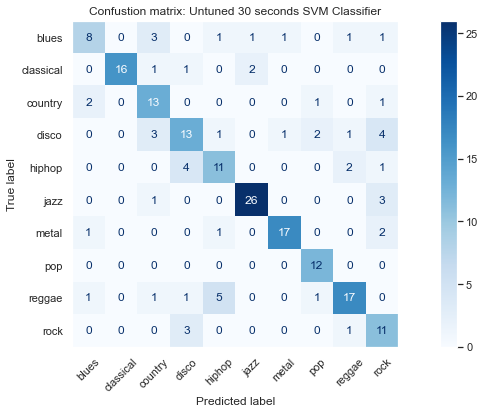

Accuracy : 0.72
Macro F-1 Score : 0.72


In [8]:
# Evaluate Model on Test set
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(predsTestsvm, y_test, class_labels,
                                    'Confustion matrix: Untuned 30 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the raw csv file

In [9]:
parameters = {"kernel": ['linear', 'rbf', 'sigmoid'],
            "C": [0.001, 0.01, 0.1, 1, 10],
            "gamma": [0.001, 0.01, 0.1, 1]}
print(parameters)

{'kernel': ['linear', 'rbf', 'sigmoid'], 'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]}


In [10]:
tune_svm = GridSearchCV(estimator = model_svm, param_grid = parameters, cv = 5)
tune_svm.fit(X_dev, y_dev)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'sigmoid']})

In [11]:
print("Best Score :", tune_svm.best_score_)
print("Best Parameters :",tune_svm.best_params_)

Best Score : 0.73125
Best Parameters : {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [12]:
predsDevsvm_tuned = tune_svm.predict(X_dev)
predsTestsvm_tuned = tune_svm.predict(X_test)

print("Score on Dev data for svm using GridSearchCV:", accuracy_score(y_dev, predsDevsvm_tuned))
print("Score on Test data for svm using GridSearchCV:",accuracy_score(y_test, predsTestsvm_tuned))

Score on Dev data for svm using GridSearchCV: 0.99875
Score on Test data for svm using GridSearchCV: 0.77


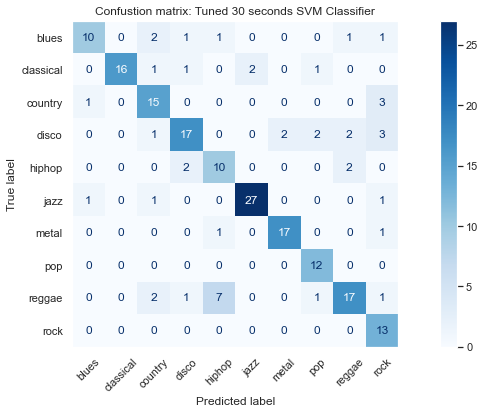

Accuracy : 0.77
Macro F-1 Score : 0.77


In [13]:
# Evaluate Model on Test set
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(predsTestsvm_tuned, y_test, class_labels,
                                    'Confustion matrix: Tuned 30 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### Dimensionality reduction of data using PCA

In [14]:
# Principal Component Analysis 
### cite : https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

# create the PCA instance
pca = PCA(n_components=30)
# fit on data
pca_data = pca.fit_transform(X_dev)
pca_data_test = pca.transform(X_test)
# pca_data_dev = pca.transform(X_dev)
PCA_df= pd.DataFrame(data=pca_data)
y_dev.index = PCA_df.index
pca_final=pd.concat([PCA_df,y_dev], axis = 1)
# access values
print("Explained Variance of each component:",pca.explained_variance_)
print("Sum of Explained Variance:", sum(pca.explained_variance_ratio_))

Explained Variance of each component: [0.27766419 0.24831461 0.10817539 0.0735775  0.05921353 0.04313114
 0.03041835 0.02485929 0.02357102 0.0185913  0.01458576 0.01445453
 0.01236632 0.01085372 0.01042907 0.00964281 0.00916207 0.00839633
 0.00793383 0.007288   0.0072332  0.00675785 0.00606161 0.0056078
 0.00551618 0.00512619 0.00504659 0.00465303 0.00453888 0.00424035]
Sum of Explained Variance: 0.9554581320959247


In [15]:
pca_final.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,label
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209189,-0.328522,0.078992,-0.157338,...,0.038687,-0.013735,0.078342,0.043062,-0.020036,0.029268,0.075823,0.061957,-0.002228,blues
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098224,-0.077306,0.046260,-0.040617,0.094602,...,-0.046128,-0.069489,-0.017079,0.047087,0.035360,0.008756,0.050260,0.014539,-0.018084,rock
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066611,-0.197731,0.041886,0.013271,...,0.035832,0.010318,-0.060832,-0.158323,-0.007003,0.116047,0.031020,0.002193,-0.031549,reggae
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091608,0.131256,-0.044358,0.123938,...,0.002583,-0.002347,-0.015666,0.033186,-0.035766,0.014651,0.003094,0.018971,-0.025796,rock
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025042,-0.233485,0.295028,0.131572,...,-0.081790,0.058147,-0.018631,-0.017101,-0.000729,-0.049365,-0.036298,-0.019051,0.015491,reggae


### PCA - Original Model
Building a model with no parameter tuning and using the PCA data

In [16]:
model_pca = SVC()
model_pca.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainsvm = model_pca.predict(pca_data)
pcaTestsvm = model_pca.predict(pca_data_test)

In [17]:
pcatestsvm_score =  accuracy_score(y_test, pcaTestsvm)
pcasvm_score = accuracy_score(y_dev, pcaTrainsvm)

In [18]:
print("Classification Score for SVM Classifier on Train dataset:\n")
print("Train Score : ", pcasvm_score)
print("--------------------------------------------------------")
print("Classification Score for SVM Classifier on Test dataset:\n")
print("Test Score :", pcatestsvm_score)

Classification Score for SVM Classifier on Train dataset:

Train Score :  0.85625
--------------------------------------------------------
Classification Score for SVM Classifier on Test dataset:

Test Score : 0.775


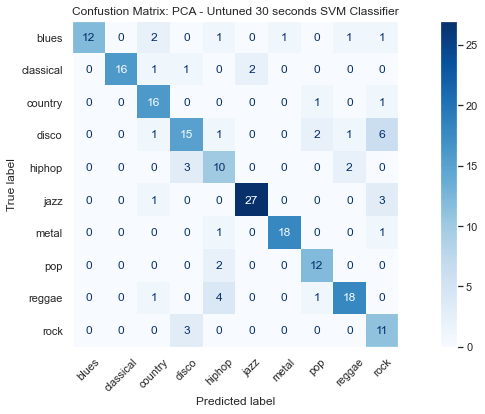

Accuracy : 0.78
Macro F-1 Score : 0.77


In [19]:
# Evaluate Model
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(pcaTestsvm, y_test, class_labels,
                                    'Confustion Matrix: PCA - Untuned 30 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)

### PCA - Tuned Model
Building a model with hyperparameters tuning using 5-fold cross validation with GridSearchCV and the PCA data

In [20]:
pca_final.iloc[:,:30]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.777410,0.193198,-0.058681,-0.180358,-0.005488,-0.099418,-0.209189,-0.328522,0.078992,-0.157338,...,0.041063,0.038687,-0.013735,0.078342,0.043062,-0.020036,0.029268,0.075823,0.061957,-0.002228
1,-0.599829,0.260505,0.001988,-0.047122,0.131503,-0.098224,-0.077306,0.046260,-0.040617,0.094602,...,-0.041297,-0.046128,-0.069489,-0.017079,0.047087,0.035360,0.008756,0.050260,0.014539,-0.018084
2,-0.246233,-0.118150,0.065454,-0.036683,0.486624,-0.150015,-0.066611,-0.197731,0.041886,0.013271,...,0.088479,0.035832,0.010318,-0.060832,-0.158323,-0.007003,0.116047,0.031020,0.002193,-0.031549
3,-0.748761,0.347893,-0.050810,-0.060772,0.094122,0.043072,-0.091608,0.131256,-0.044358,0.123938,...,-0.015485,0.002583,-0.002347,-0.015666,0.033186,-0.035766,0.014651,0.003094,0.018971,-0.025796
4,0.390897,0.250941,-0.198188,0.293123,0.621651,0.005957,-0.025042,-0.233485,0.295028,0.131572,...,0.017183,-0.081790,0.058147,-0.018631,-0.017101,-0.000729,-0.049365,-0.036298,-0.019051,0.015491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,-0.565572,0.422083,0.328459,0.111136,-0.153392,-0.133144,0.121274,0.170833,0.181535,-0.003548,...,0.293158,-0.013221,0.058098,0.047991,0.082296,-0.065198,0.015111,-0.022493,-0.003685,0.006048
796,0.258810,-0.934083,0.031836,0.495334,0.077338,-0.114135,0.171020,-0.128289,0.103751,0.171788,...,0.029115,-0.006572,-0.040898,0.058107,0.157340,0.040754,-0.132450,-0.037645,0.098647,-0.000561
797,1.243638,0.799851,0.648936,0.304699,-0.379732,0.291342,-0.171435,-0.020327,0.029573,-0.338985,...,-0.005145,-0.005009,0.014084,-0.005221,0.054093,-0.002200,-0.062810,-0.102748,-0.034462,0.005716
798,0.251711,0.398993,-0.418890,-0.045822,0.030828,0.140385,-0.063129,-0.085617,-0.096345,0.127783,...,0.080252,-0.048875,0.016659,-0.003653,-0.024692,0.125774,-0.097164,-0.052864,0.028607,-0.102050


In [21]:
model_pca_tuned = tune_svm
model_pca_tuned.fit(pca_final.iloc[:,:30],pca_final.iloc[:,30])
pcaTrainsvm_tuned = model_pca_tuned.predict(pca_data)
pcaTestsvm_tuned = model_pca_tuned.predict(pca_data_test)

In [22]:
pcatestsvm_score =  accuracy_score(y_test, pcaTestsvm)
pcasvm_score = accuracy_score(y_dev, pcaTrainsvm)

In [23]:
print("Classification Score for SVM Classifier on Train dataset:\n")
print("Train Score : ", pcasvm_score)
print("--------------------------------------------------------")
print("Classification Score for SVM Classifier on Test dataset:\n")
print("Test Score :", pcatestsvm_score)

Classification Score for SVM Classifier on Train dataset:

Train Score :  0.85625
--------------------------------------------------------
Classification Score for SVM Classifier on Test dataset:

Test Score : 0.775


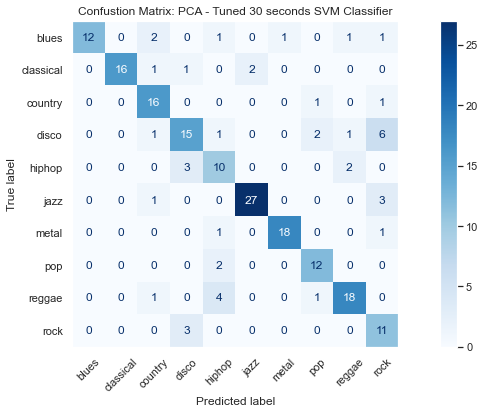

Accuracy : 0.78
Macro F-1 Score : 0.77


In [24]:
# Evaluate Model
class_labels = list(model_svm.classes_)
macro_f1, accuracy = evaluate_model(pcaTestsvm, y_test, class_labels,
                                    'Confustion Matrix: PCA - Tuned 30 seconds SVM Classifier')
print('Accuracy : %.2f'%accuracy)
print('Macro F-1 Score : %.2f'%macro_f1)